# 🐍 Python + Señales Biomédicas  

Es posible trabajar con señales biomédicas del repositorio **PhysioNet** directamente desde Python usando el paquete **`wfdb`**.  

`wfdb` es un paquete especializado para manipular bases de datos fisiológicas (ECG, PPG, EEG, presión arterial, etc.).  
Fue creado como interfaz a la librería clínica **WaveForm DataBase (WFDB)** ampliamente usada en investigación biomédica.  

---

## 🔹 Instalación en Colab  

```python
!pip install wfdb
```

In [1]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 68.9 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.2 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.


In [2]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import iirnotch, filtfilt

# Cargar datos desde Physionet:

En esta practica trabajaremos con el repositorio **arritmias del MIT-BIH** (disponible en:
https://physionet.org/content/mitdb/1.0.0/)

La base de datos de arritmias del MIT-BIH contiene 48 extractos de media hora de grabaciones de ECG ambulatorio de dos canales, obtenidos de 47 sujetos estudiados por el Laboratorio de Arritmias del BIH.


Es importante reconocer que los conjuntos de datos en PhysioNet contiene lo siguiente:


* **.hea → Header file**: Contiene metadatos del registro:

  * Frecuencia de muestreo (fs)

  * Número de canales (derivaciones)

  * Duración en muestras

  * Nombre de los archivos de datos

  * Ganancia y unidades de cada canal

* **.dat → Data file**: Señal fisiológica cruda en formato binario (ECG, PPG, EEG, etc.).

* **.atr → Annotations**: (beat annotation)
Contiene anotaciones manuales de latidos cardíacos (tipo: normal, PVC, fibrilación, etc.) o eventos clínicos.

In [12]:
import wfdb
data = 'content/mitdb/100'

## Funciones principales de wfdb
Lectura de señales fisiológicas

* wfdb.rdrecord() → carga un registro completo (ej. ECG continuo, PPG, etc.).

* wfdb.rdann() → carga anotaciones (latidos, diagnósticos, etc.).

* wfdb.rdsamp() → otra forma de leer señales + metadatos en un solo paso.

In [13]:
# Cargar un registro de la base MIT-BIH Arrhythmia
# Descargar solo el registro 100
wfdb.dl_database('mitdb', records=['100'], dl_dir='/mitdb')
record = wfdb.rdrecord(data)
annotation = wfdb.rdann(data, 'atr')

Generating record list for: 100
Generating list of all files for: 100
Finished downloading files


El objeto record es de tipo wfdb.io.record.Record, que funciona como un contenedor de toda la señal.

Atributos más importantes de record:

* record.fs → frecuencia de muestreo (ej. 360 Hz).

* record.sig_name → nombres de los canales (ej. ['MLII', 'V5']).

* record.n_sig → número de señales.

* record.sig_len → número total de muestras.

* record.p_signal → señal en un numpy.ndarray de forma (muestras, canales).

* record.base_datetime → fecha/hora de inicio (si está disponible).

* record.comments → comentarios del encabezado.

In [14]:
print("Frecuencia de muestreo:", record.fs)
print("Canales:", record.sig_name)
print("Número de canales:", record.n_sig)
print("Número de muestras:", record.sig_len)


Frecuencia de muestreo: 360
Canales: ['MLII', 'V5']
Número de canales: 2
Número de muestras: 650000


In [15]:
# Seleccionar todo el ECG del primer canal
ECG = record.p_signal[:,0]

# Vector de tiempo desde 0 hasta la duración total
# Frecuencia de muestreo
fs = record.fs
# Número total de muestras
N = len(ECG)
# Vector
t = np.arange(N) / fs

# 📊 Graficar un ECG en Python

Para visualizar una señal de ECG en Python usamos la librería **Matplotlib**.

Para ello se deben seguir los siguientes pasos:

* Crear un figure: plt.figure(figsize=(12,4))

* Crear la grafica: plt.plot(x, y, color='blue')

* congigurar el plot:
  * plt.title(f" ")
  * plt.xlabel(f" ")
  * plt.ylabel(f" ")
  * plt.grid(True)

* Mostrar el grafico: plt.show()

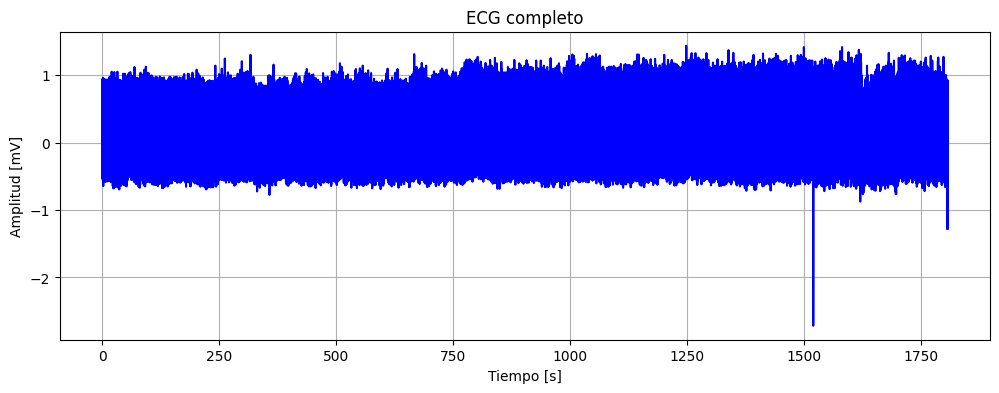

In [16]:
# Graficar
plt.figure(figsize=(12,4))
plt.plot(t, ECG, color='blue')
plt.title(f"ECG completo")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud [mV]")
plt.grid(True)
plt.show()

Ahora deberemos delimitar el ECG al periodo de interés

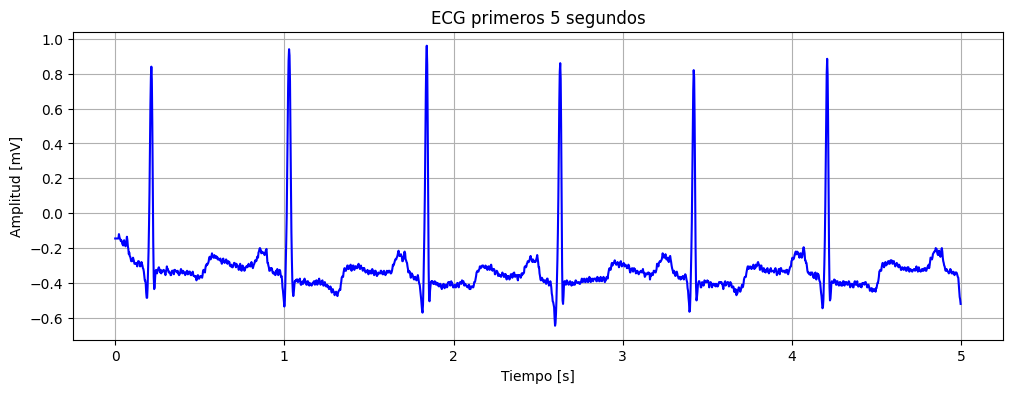

In [17]:
# Duración a graficar en segundos
duration = 5  # segundos

# Número de muestras correspondientes
num_samples = int(duration * fs)

# Sub-señal y sub-tiempo
t_plot = t[:num_samples]
ECG_segment = ECG[:num_samples]

# Graficar
plt.figure(figsize=(12,4))
plt.plot(t_plot, ECG_segment, color='blue')
plt.title(f"ECG primeros {duration} segundos")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud [mV]")
plt.grid(True)
plt.show()

# Preprocesamiento en señales biomédicas

**El preprocesamiento es la etapa inicial del análisis de señales biomédicas, cuyo objetivo es mejorar la calidad de la señal antes de aplicar cualquier técnica de análisis o extracción de características. Esto es crucial porque las señales biomédicas, como el ECG, EEG o EMG, son muy sensibles al ruido y a interferencias externas.**

Durante el preprocesamiento se realizan tareas como:

- Eliminación de artefactos (movimiento, parpadeo, respiración, etc.)

- Filtrado de ruido eléctrico

- Normalización o escalado de la señal

- Segmentación o selección de ventanas de interés


## Eliminación de ruido eléctrico

El ruido eléctrico es muy común en señales biomédicas y puede provenir de:

Interferencias de la red eléctrica (50 o 60 Hz según el país)

Equipos electrónicos cercanos

Mal contacto de electrodos

Este ruido puede enmascarar la información real de la señal, por lo que es fundamental eliminarlo antes de cualquier análisis.

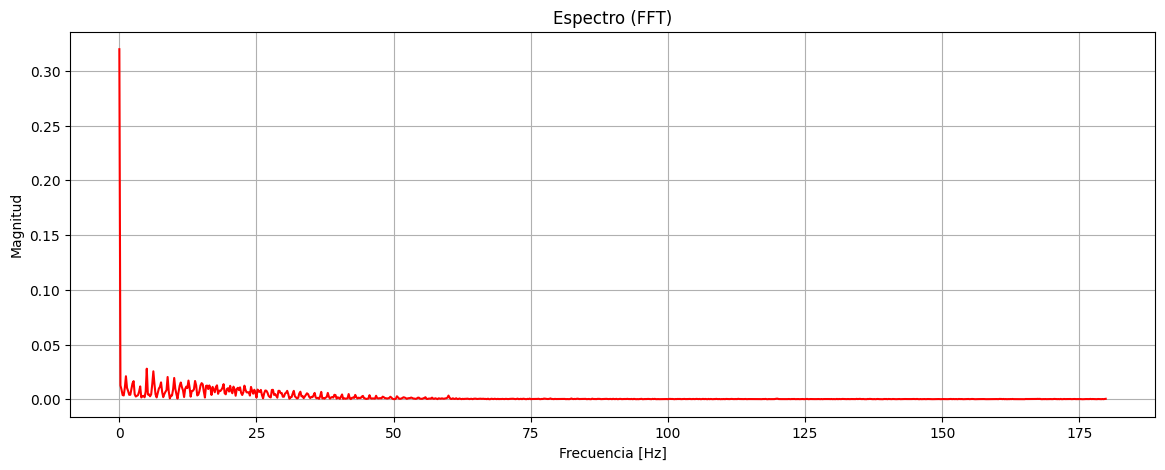

In [20]:
# ---------- FFT ----------
N = len(ECG_segment)                     # número de muestras
ECG_fft = np.fft.fft(ECG_segment)        # transformada
ECG_fft = np.abs(ECG_fft) / N            # magnitud normalizada
freqs = np.fft.fftfreq(N, 1/fs)          # vector de frecuencias

# ---------- Usar solo la mitad positiva ----------
half = N // 2
freqs = freqs[:half]
ECG_fft = ECG_fft[:half]

# ---------- Gráficas ----------
plt.figure(figsize=(14,5))
plt.plot(freqs, ECG_fft, color='red')
plt.title("Espectro (FFT)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Magnitud")
#plt.xlim(0, 100)  # ECG tiene info relevante < 50 Hz
plt.grid(True)

# Filtro Notch

Una técnica muy usada para eliminar ruido eléctrico de frecuencia específica es el filtro Notch.

El filtro Notch es un filtro muy selectivo que atenúa una frecuencia determinada sin afectar mucho las demás frecuencias de la señal.

* f0 es la frecuencia que queremos eliminar.

* Q controla qué tan estrecho es el “corte”: mayor Q = más selectivo.

* filtfilt aplica el filtro de manera que no introduce desfase en la señal.

Por ejemplo, en países con red eléctrica a 60 Hz, se usa un notch en 60 Hz para eliminar el zumbido de la red.

Matemáticamente, un filtro Notch puede diseñarse para cortar una banda muy estrecha alrededor de la frecuencia de interferencia.



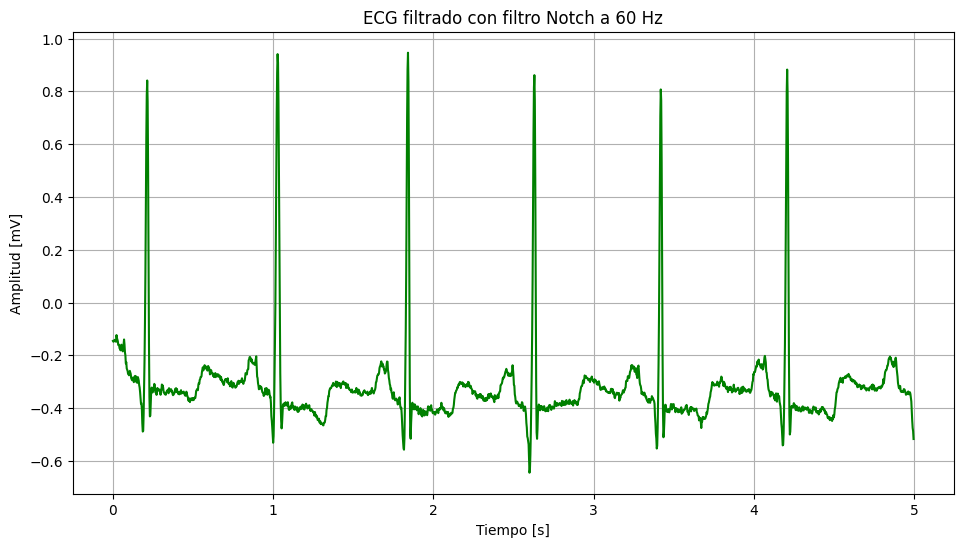

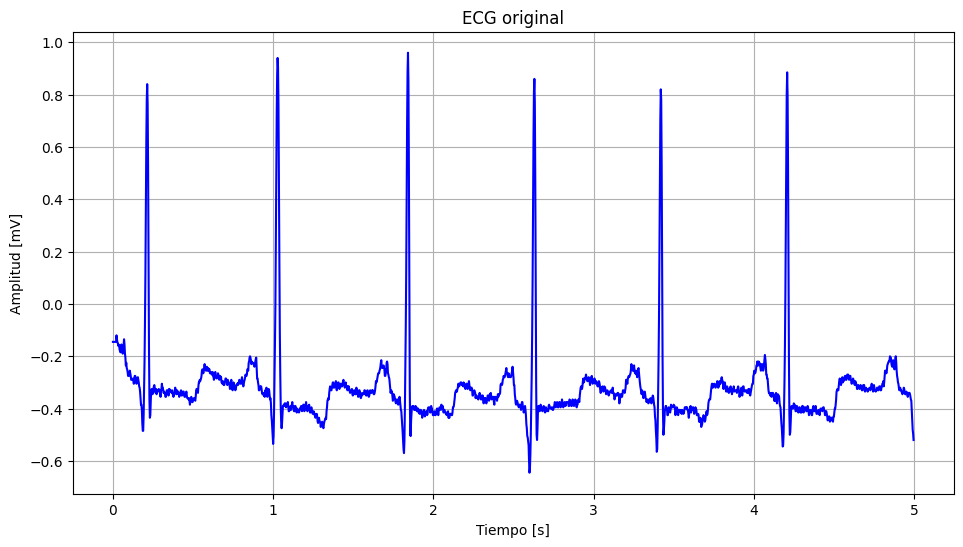

In [21]:
# Frecuencia a eliminar
f0 = 60  # Hz

# Factor de calidad (determina el ancho de banda del filtro)
Q = 20.0  # Un valor más alto significa un filtro más estrecho

# Diseño del filtro notch usando f0, Q y fs
b, a = iirnotch(f0, Q, fs)

# Aplicar el filtro a la señal
ECG_filtered = filtfilt(b, a, ECG_segment)

# Graficar la señal filtrada
plt.figure(figsize=(25,6))
plt.subplot(1,2,1)
plt.plot(t_plot, ECG_filtered, color='green')
plt.title(f"ECG filtrado con filtro Notch a {f0} Hz")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud [mV]")
plt.grid(True)
plt.show()

plt.figure(figsize=(25,6))
plt.subplot(1,2,2)
plt.plot(t_plot, ECG_segment, color='blue')
plt.title(f"ECG original")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud [mV]")
plt.grid(True)
plt.show()